In [45]:
# Imports
from openpiv import tools, pyprocess, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Only used in Jupyter-lab, comment if .py file
%matplotlib inline

# Parameters
## Displacement Field
df_winsize = 30 # pixels, interrogation window size in frame A #32
df_searchsize = df_winsize # pixels, search in image B #38
df_overlap = df_winsize//2 # pixels, 50% overlap #12 (smaller than df_searchsize)(larger seems to be better)
df_dt = 1 # sec, time interval between pulses
df_sig2noise_method = 'peak2peak' # None, 'peak2peak', 'peak2mean'
df_normalized_correlation = False

## Replace Outliers
replace_outliers_method = 'localmean' # 'localmean', 'disk', 'distance'
iterative = False # [0] keep NaN vectors [1] iteratively replace outliers [2] set those vectors to set_num
set_num = 0

## Scaling
# Trail 1
pixels_per_mm = 17.3322

## File
output_dir = '.' # Don't add '/' at the end

still_name =  "10"
moving_name = "10"

## Showing Vector Field
show_vector_field = False

trial = "5";
top_dir = "../../Experiment 11/trial " + trial + "/cropped/";
still_path = top_dir + "still/";
moving_path = top_dir + "moving/";
extension = '.JPG'

still = still_path + still_name + extension
moving = moving_path + moving_name + extension

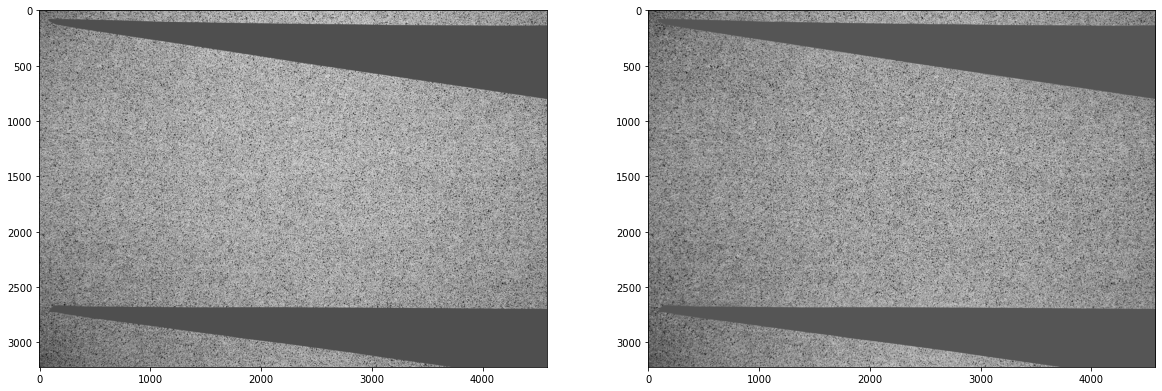

In [46]:
frame_a  = tools.imread( still )
frame_b  = tools.imread( moving )

fig,ax = plt.subplots(1,2,figsize=(20,16))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [47]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=df_winsize, 
                                                       overlap=df_overlap, 
                                                       dt=df_dt, 
                                                       search_area_size=df_searchsize, 
                                                       sig2noise_method=df_sig2noise_method,
                                                       normalized_correlation=df_normalized_correlation)

x0, y0 = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                  search_area_size=df_searchsize, 
                                  overlap=df_overlap )

In [48]:
# Remove elements where signal to noise is more than 3, which it never is with real data
sig2noisenew = np.delete(sig2noise.flatten(), np.where(sig2noise > 3), axis=0)

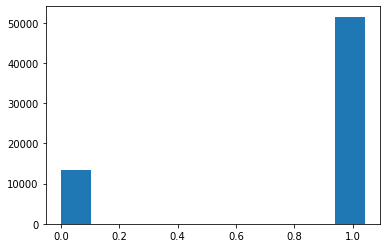

In [49]:
# if you need more detailed look, first create a histogram of sig2noise
# to see where is a reasonable limit
if df_sig2noise_method != None:
    plt.hist(sig2noisenew)

In [50]:
if df_sig2noise_method != None:
    user_thresh = float(input("Enter threshold value"))
else:
    user_thresh = 0

Enter threshold value .9


In [51]:
def get_nan_num(arr):
    num = 0
    for i in range(0,len(arr)):
        for j in range(0,len(arr[0])):
            val = arr[i][j]
            if np.isnan(val):
                num = num + 1
    return num


u1, v1, mask1 = validation.sig2noise_val( u0.copy(), v0.copy(), 
                                            sig2noise, 
                                            threshold = user_thresh )

In [52]:
# Calculate changes is nan (same values for u1 and v1)
total_num = (len(u0)*len(u0[0]))

u0_nan_num = get_nan_num(u0)
u0_nan_per = 100*u0_nan_num/total_num
u1_nan_num = get_nan_num(u1)
u1_nan_per = 100*u1_nan_num/total_num
u1_nan_change_num = u1_nan_num - u0_nan_num
u1_nan_change_per = (u1_nan_num - u0_nan_num)/total_num*100

print("u0,v0 -> u1,v1")
print("{0: <12s}: {1}/{2} ({3: <.2f}%)".format("old nan_num",u0_nan_num,total_num,u0_nan_per))
print("{0: <12s}: {1}/{2} ({3: <.2f}%)".format("new nan_num",u1_nan_num,total_num,u1_nan_per))
print("{0: <12s}: {1} ({2: <.2f})%".format("nan change",u1_nan_change_num,u1_nan_change_per))


u0,v0 -> u1,v1
old nan_num : 12394/64752 (19.14%)
new nan_num : 13261/64752 (20.48%)
nan change  : 867 (1.34)%


In [53]:
# filter out outliers that are very different from the
# neighbours

# Replace all nan with 0
def set_nan_zero(arr):
    arr_new = arr.copy()
    for i in range(0,len(arr_new)):
        for j in range(0,len(arr_new[0])):
            val = arr_new[i][j]
            if np.isnan(val):
                arr_new[i][j] = 0
    return arr_new

# Print change in NaN from array 1 to array 2
# Returns u2_nan_per
def print_changes(arr1, arr2):
    # Calculate changes is nan (same values for u2 and v2)
    total_num = (len(u1)*len(u1[0]))
    u1_nan_num = get_nan_num(arr1)
    u1_nan_per = 100*u1_nan_num/total_num
    u2_nan_num = get_nan_num(arr2)
    u2_nan_per = 100*u2_nan_num/total_num
    u2_nan_change_num = u2_nan_num - u1_nan_num
    u2_nan_change_per = (u2_nan_num - u1_nan_num)/total_num*100
    print("u1,v1 -> u2,v2")
    print("{0: <12s}: {1}/{2} ({3: <.2f}%)".format("old nan_num",u1_nan_num,total_num,u1_nan_per))
    print("{0: <12s}: {1}/{2} ({3: <.2f}%)".format("new nan_num",u2_nan_num,total_num,u2_nan_per))
    print("{0: <12s}: {1} ({2: <.2f})%".format("nan change",u2_nan_change_num,u2_nan_change_per))
    return u2_nan_per

# Run first pass of replace_outliers
u2, v2 = filters.replace_outliers( u1.copy(), v1.copy(), 
                                    method=replace_outliers_method, 
                                    max_iter=1, 
                                    kernel_size=3)

print_changes(u1,u2)

if iterative == 1:
    # Allow for iterative replace_outliers until there are no more NaN vectors
    u2_nan_per = 1
    u2 = u1.copy()
    v2 = v1.copy()

    while(u2_nan_per != 0):
        # CHECK if needed
        u2, v2 = filters.replace_outliers( u2.copy(), v2.copy(), 
                                          method=replace_outliers_method, 
                                          max_iter=1, 
                                          kernel_size=3)

        u2_nan_per = print_changes(u1,u2)
elif iterative == 2:
    u2, v2 = filters.replace_outliers( u1.copy(), v1.copy(), 
                                      method=replace_outliers_method, 
                                      max_iter=1, 
                                      kernel_size=3)
    
    # Replace all nan with 0
    u2 = set_nan_zero(u2)
    v2 = set_nan_zero(v2)
    
    print_changes(u1,u2)

u1,v1 -> u2,v2
old nan_num : 13261/64752 (20.48%)
new nan_num : 8558/64752 (13.22%)
nan change  : -4703 (-7.26)%


In [54]:
# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x1, y1, u3, v3 = tools.transform_coordinates(x0.copy(), y0.copy(), u2.copy(), v2.copy())

x2, y2, u4, v4 = scaling.uniform(x1.copy(), y1.copy(), u3.copy(), v3.copy(), 
                               scaling_factor = pixels_per_mm ) # pixels/mm (converts pixel coordinates to mm coordinates)

#save in the simple ASCII table format
#save_filename = './' + output_dir + '/fsss_' + still_name + '_' + moving_name + '.txt'
save_filename = './' + output_dir + '/fsss_s' + still_name[4:] + '_m' + moving_name[4:] + '.txt'
tools.save(x2, y2, u4, v4, mask1, save_filename)
tools.save(x2, y2, u4, v4, mask1, './' + output_dir + '/fsss.txt')

infile = open(save_filename,'r+')
content = infile.readlines() #reads line by line and out puts a list of each line
content[0] = '#df_winsize: ' + str(df_winsize) + '\n#df_searchsize: ' + str(df_searchsize) +\
             '\n#df_overlap: ' + str(df_overlap) + '\n#df_dt: ' + str(df_dt) + '\n#df_sig2noise_method: ' + str(df_sig2noise_method) +\
             '\n#df_normalized_correlation: ' + str(df_normalized_correlation) +\
             '\n#replace_outliers_method: ' + str(replace_outliers_method) + '\n#pixels_per_mm: ' + str(pixels_per_mm) +\
             '\n#still_name: ' + str(still_name) + '\n#moving_name: ' + str(moving_name) +\
             '\n#iterative: ' + str(iterative) +\
             '\n#set_num: ' + str(set_num) +\
             '\n#user_thresh: ' + str(user_thresh) + '\n#x y u v mask\n' #replaces content of the 2nd line (index 1)

infile.seek(0)
infile.writelines(content)
infile.close()

print("Saved to", save_filename)

Saved to ././fsss_s_m.txt


In [55]:
# Delete vectors to make it easier to graph
def cut_arr_n(arr, n):
    if n <= 0:
        return arr
    else:
        new_arr = cut_arr(arr)
        return cut_arr_n(new_arr,n-1)

# Takes out at most 3 nodes out of every 4 in a square of data
def cut_arr(arr):
    arr_new = np.ndarray(shape=(int(np.ceil(len(arr)/2)),int(np.ceil(len(arr[0])/2))))
    for i in range(0,len(arr)):
        for j in range(0,len(arr[0])):
            if i % 2 == 0 and j % 2 == 0:
                arr_new[int(i/2)][int(j/2)] = int(arr[i][j])
    return arr_new

if(show_vector_field):
    cuts = 2

    x_v = cut_arr_n(x1.copy(),cuts)
    y_v = cut_arr_n(y1.copy(),cuts)
    u_v = cut_arr_n(u3.copy(),cuts)
    v_v = cut_arr_n(v3.copy(),cuts)
    mask_v = cut_arr_n(mask1.copy(),cuts)

    #save in the simple ASCII table format
    tools.save(x_v, y_v, u_v, v_v, mask_v, './' + output_dir + '/fsss_view.txt' )

In [56]:
if(show_vector_field):
    fig, ax = plt.subplots(figsize=(15,15))
    tools.display_vector_field('./' + output_dir + '/fsss_view.txt', 
                               ax=ax, scaling_factor=1, 
                               scale=2000, # scale defines here the arrow length (smaller = longer)
                               width=0.0015, # width is the thickness of the arrow
                               on_img=True, # overlay on the image
                               image_name=still);